In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import json
import copy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pygam import LinearGAM, s, l

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/misc_projects/pyfunc/')
from func import get_fdr_p_df, corr_true_pred, root_mean_squared_error, get_reg, get_stratified_cv, update_progress, cross_val_score_nuis

In [4]:
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
extra_str = '' # '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 200
parc_variant = 'orig' # 'orig' 'cortex_only'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_str = parc_str, parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight,
                                                                                       parc_variant = parc_variant)

In [5]:
os.environ['MODELDIR']

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount'

In [6]:
# predictiondir = os.path.join(os.environ['MODELDIR'], 'predict_pheno')
# predictiondir = os.path.join(os.environ['MODELDIR'], 'predict_cog')
predictiondir = os.path.join(os.environ['MODELDIR'], 'predict_psy')
predictiondir

'/Users/lindenmp/Google-Drive-Penn/work/research_projects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount/predict_psy'

In [7]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)']

print(phenos)

metrics = ['str', 'ac']
metrics_label = ['Strength', 'Average Controllability']

algs = ['rr', 'krr_rbf']
scores = ['corr', 'rmse']
seeds = np.arange(0,100)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg']


In [8]:
a = 1; alg = algs[a]; print(alg)
s = 1; score = scores[s]; print(score)

krr_rbf
rmse


## Setup plots

In [9]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = sns.color_palette("pastel", 3)

## Load data

In [10]:
df_node = pd.read_csv(os.path.join(predictiondir, 'X.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

df_node_ac_overc = pd.read_csv(os.path.join(predictiondir, 'X_ac_c.csv'))
df_node_ac_overc.set_index(['bblid', 'scanid'], inplace = True)

df_pheno = pd.read_csv(os.path.join(predictiondir, 'y.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

c = pd.read_csv(os.path.join(predictiondir, 'c.csv'))
c.set_index(['bblid', 'scanid'], inplace = True); print(c.shape)
c.columns

(1068, 4)


Index(['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS'], dtype='object')

In [11]:
(np.sum(c.loc[:,'sex'] == 1)/c.shape[0]) * 100

45.50561797752809

In [12]:
if score == 'r2':
    my_scorer = make_scorer(r2_score, greater_is_better = True)
elif score == 'corr':
    my_scorer = make_scorer(corr_true_pred, greater_is_better = True)
elif score == 'mse':
    my_scorer = make_scorer(mean_squared_error, greater_is_better = False)
elif score == 'rmse':
    my_scorer = make_scorer(root_mean_squared_error, greater_is_better = False)
elif score == 'mae':
    my_scorer = make_scorer(mean_absolute_error, greater_is_better = False)
my_scorer

make_scorer(root_mean_squared_error, greater_is_better=False)

In [13]:
regs, param_grid = get_reg()

In [14]:
n_splits = 10

# Plots

In [15]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)

In [16]:
g = 0
gradient = np.loadtxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template.txt'))[:,g]
# sort gradient
sort_idx = np.argsort(gradient)

In [22]:
bin_size = 5

In [28]:
if 'altcontrol' in os.environ['MODELDIR']:
    c_params = np.linspace(0.75, 0.25, 3)
else:
    c_params = np.array([10, 100, 1000, 10000])

c_params

# control_c = c_params[3]
control_c = None
print(control_c)

if control_c == None:
    metrics = ['str', 'ac']
    metrics_label = ['Strength', 'Average Controllability']
else:
    metrics = ['ac',]
    metrics_label = ['Average Controllability',]

phenos = ['Psychosis_Positive','Psychosis_NegativeDisorg']
phenos_label = ['Psychosis (Positive)','Psychosis (Negative)']
phenos_short = ['Psy. (pos)','Psy. (neg)']

None


str Psychosis_NegativeDisorg
(1068, 200)
(1068,)
Full model score: 1.0171486556603173 0.006721732204419724
Computing accuracy for non overlapping windows
ac Psychosis_NegativeDisorg
(1068, 200)
(1068,)
Full model score: 1.0260841285082625 0.01064925431263984
Computing accuracy for non overlapping windows


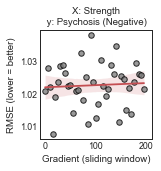

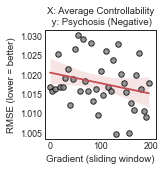

In [33]:
my_r = pd.DataFrame(index = metrics, columns = phenos)
my_pvals = pd.DataFrame(index = metrics, columns = phenos)

for m, metric in enumerate(metrics):
    for p, pheno in enumerate(phenos):
        print(metric, pheno)
        
        # Get X and y data
        if control_c == None:
            X = df_node.filter(regex = metric)
        else:
            X = df_node_ac_overc.filter(regex = metric + '_c' + str(control_c) + '_')
        print(X.shape)
        y = df_pheno.loc[:,pheno]; print(y.shape)

        # set regression estimator
        reg = copy.deepcopy(regs[alg])
    
        # sort and get cross-val
        X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X, y = y, c = c, n_splits = n_splits)

        # get full model score
        nuis_model, _ = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
        if score == 'rmse': nuis_model = np.abs(nuis_model)
        main_score_nuis = nuis_model.mean()
        main_sterr_nuis = nuis_model.std() / np.sqrt(n_splits)
        print('Full model score:', main_score_nuis, main_sterr_nuis)
        
        print('Computing accuracy for non overlapping windows')
        # reorder X by gradient
        X_sort_grad = X_sort.iloc[:,sort_idx]
        
        window_start = np.arange(0,num_parcels - bin_size + 1, bin_size)
        num_windows = len(window_start)

        # compute accuracy for non overlapping windows
        window_score = np.zeros(num_windows,)
        window_sterr = np.zeros(num_windows,)

        for i, w in enumerate(window_start):
            Xl = X_sort_grad.iloc[:,w:w+bin_size]
            cv_results, _ = cross_val_score_nuis(X = Xl, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
            if score == 'rmse': cv_results = np.abs(cv_results)
            window_score[i] = cv_results.mean()
            window_sterr[i] = cv_results.std() / np.sqrt(n_splits)
            
        if metric == 'str':
            window_score_str = window_score.copy()
        elif metric == 'ac':
            window_score_ac = window_score.copy()
            
        # plot
        f, ax = plt.subplots()
        if control_c == None:
            f.set_figwidth(2)
            f.set_figheight(2)
        else:
            f.set_figwidth(1.25)
            f.set_figheight(1.25)
        sns.regplot(x = window_start, y = window_score, color = 'r', scatter = False)
        
#         my_r.loc[metric,pheno] = sp.stats.spearmanr(window_start, window_score)[0]
#         my_pvals.loc[metric,pheno] = sp.stats.spearmanr(window_start, window_score)[1]
        my_r.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score)[0]
        my_pvals.loc[metric,pheno] = sp.stats.pearsonr(window_start, window_score)[1]
        
        # non overlapping windows
        if len(window_start) > len(window_score): window_start = window_start[:len(window_score)]
        plt.scatter(x = window_start, y = window_score, marker = 'o', s = 30, edgecolors = 'black', facecolors = 'gray', alpha=0.8, linewidth = 1)
        ax.tick_params(pad = -2)

        ax.set_xlabel('Gradient (sliding window)')
        ax.set_ylabel('RMSE (lower = better)')
#         ax.set_xlim([-bin_size, num_parcels])
#         ax.set_xlim([-bin_size*2, num_parcels+bin_size*2])
        ax.set_xlim([-10, num_parcels+10])
        if control_c != None:
            ax.set_ylim([0.995, 1.04])

        ax.set_title('X: ' + metrics_label[m] + '\n y: ' + phenos_label[p])
#         ax.set_title(metrics_label[m])

        if control_c == None:
            f.savefig('gradient_'+str(g)+'_window_'+metric+'_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight')
        else:
            f.savefig('c_' + str(control_c) + '_gradient_'+str(g)+'_window_'+metric+'_'+pheno+'.svg', dpi = 300, bbox_inches = 'tight')

In [34]:
# my_pvals_corr = get_fdr_p_df(my_pvals, rows = False)

In [35]:
my_r

,Psychosis_NegativeDisorg
str,0.0577813
ac,-0.25512


In [36]:
my_pvals

,Psychosis_NegativeDisorg
str,0.723227
ac,0.112112
